# 用于验证回测框架的独立程序 (V5 - 信号叠加与重叠交易模型)

**目的**: 实现一个“无限资金，独立交易”的回测模型。每个信号都独立触发一笔固定
持仓周期的交易，所有交易的生命周期可以互相重叠。

**核心逻辑**:
1.  引入全新的 `run_overlapping_trades_backtest` 函数。
2.  对每一个非零信号，都计算其从 T+1 到 T+11 (持仓10个周期) 的独立净收益率。
3.  将每笔交易的净收益率在其平仓日进行“实现”，构建一个已实现盈亏的时间序列。
4.  使用单利模型对已实现盈亏流进行累加，生成最终的权益曲线。
5.  在任一时刻的总仓位，是所有当前活跃的重叠交易的仓位之和。

# 用于验证回测框架的独立程序 (V6 - 修正 NullFrequencyError)

**目的**: 修正 V5 版本中因时间序列索引丢失频率信息而导致的 `NullFrequencyError`。

**核心变更**:
1.  在 `run_overlapping_trades_backtest` 函数中，改变了“已实现盈亏流”的构建方式。
2.  不再使用 `index.shift()`（它需要 `freq` 信息），而是改用 `series.shift()`（它移动数据的位置）。
3.  这种新方法更稳健，不依赖于索引的频率属性，能正确处理不完全规律的时间序列。

In [31]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path

---
## 1. 日志和绘图设置

In [32]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数 (源于旧代码)

In [33]:
def run_overlapping_trades_backtest(prices, signals, initial_capital, commission_rate, holding_period):
    """
    执行一个基于信号叠加和重叠交易的回测。
    每个信号都独立触发一笔有固定生命周期的交易。
    使用单利模型。

    返回:
    - pd.DataFrame: 包含回测结果的DataFrame。
    - pd.Series: 包含每笔交易的净收益率的序列。
    """
    logging.info(f"🤔🤔开始执行重叠交易回测 (持仓周期: {holding_period} bars)...")

    # --- 1. 计算每笔独立交易的净收益率 ---
    
    active_signals = signals[signals != 0]

    # 使用 shift 获取每笔交易的入场价和出场价
    # 信号在 T-1 时刻产生
    # 入场价是 T 时刻的价格 (因此对价格序列向前移动1位，再对齐信号索引)
    entry_prices = prices.shift(-1).reindex(active_signals.index)
    # 出场价是 T+holding_period 时刻的价格 (向前移动 holding_period+1 位)
    exit_prices = prices.shift(-(holding_period + 1)).reindex(active_signals.index)

    gross_pnl_rates = active_signals * (exit_prices / entry_prices - 1)
    
    trade_commissions = 2 * commission_rate
    net_pnl_rates = gross_pnl_rates - trade_commissions
    
    net_pnl_rates.dropna(inplace=True)
    
    logging.info(f"共识别出 {len(net_pnl_rates)} 笔可完整执行的交易。")

    # --- 2. 构建已实现盈亏流 (Realized PnL Stream) ---
    # ## MODIFIED: 修正 NullFrequencyError 的实现方式 ##
    #
    # **旧方法问题**: `net_pnl_rates.index.shift()` 尝试对一个没有`freq`属性的索引进行日历运算，导致报错。
    # **新方法逻辑**: 我们不移动索引，而是移动数据本身。
    
    # 1. 创建一个与主价格序列对齐的临时序列，在信号发起日记录下该笔交易的最终PnL。
    pnl_at_signal_time = net_pnl_rates.reindex(prices.index).fillna(0.0)
    
    # 2. 使用 series.shift() 将这些PnL值（数据）向未来移动。
    #    信号在 T-1 产生，交易在 T+holding_period 结束，总共移动 holding_period + 1 个位置。
    realized_pnl_stream = pnl_at_signal_time.shift(holding_period + 1).fillna(0.0)

    # --- 3. 计算权益曲线和总仓位 ---
    
    pnl_in_dollars = realized_pnl_stream * initial_capital
    cumulative_pnl = pnl_in_dollars.cumsum()
    equity_curve = initial_capital + cumulative_pnl

    positions_series = signals.rolling(window=holding_period, min_periods=0).sum()
    
    # --- 4. 结果整合 ---
    backtest_results = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'position': positions_series,
        'market_returns': prices.pct_change().fillna(0),
        'strategy_net_returns': realized_pnl_stream,
        'equity_curve': equity_curve
    })
    
    logging.info("🎉🎉重叠交易回测完成。")
    # 将 gross_pnl_rates 添加到返回值中
    return backtest_results, net_pnl_rates, gross_pnl_rates

In [34]:
def evaluate_performance(backtest_results, trade_list_series, evaluation_criteria, initial_capital, factor_data=None):
    logging.info("🤔🤔🤔开始评估策略表现 (重叠交易模型)...")

    equity_curve = backtest_results['equity_curve']
    net_returns = backtest_results['strategy_net_returns']
    market_returns = backtest_results['market_returns']
    positions = backtest_results['position']
    
    trade_returns_series = trade_list_series

    annualization_factor = 12 
    total_days = (equity_curve.index[-1] - equity_curve.index[0]).days if len(equity_curve) > 1 else 0
    duration_years = total_days / 365.0 if total_days > 0 else 1 

    total_return = (equity_curve.iloc[-1] / initial_capital) - 1 if initial_capital != 0 else 0
    annualized_return = total_return / duration_years if duration_years > 0 else 0

    monthly_net_returns = net_returns.resample('M').sum().dropna()
    monthly_market_returns = market_returns.resample('M').sum().dropna()

    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        annualized_volatility = monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        annualized_volatility = 0

    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = abs(drawdown.min())
    end_date_idx = drawdown.idxmin()
    peak_idx = equity_curve.loc[:end_date_idx].idxmax() if end_date_idx is not None else None
    max_drawdown_start_date = peak_idx
    max_drawdown_end_date = end_date_idx

    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        sharpe_ratio = monthly_net_returns.mean() / monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        sharpe_ratio = 0

    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else 0

    winning_trades_pnl = trade_returns_series[trade_returns_series > 0]
    losing_trades_pnl = trade_returns_series[trade_returns_series <= 0]
    total_trades = len(trade_returns_series)
    num_winning_trades = len(winning_trades_pnl)
    num_losing_trades = len(losing_trades_pnl)
    win_rate = num_winning_trades / total_trades if total_trades > 0 else 0
    total_profit_amount_trades = winning_trades_pnl.sum()
    total_loss_amount_trades = abs(losing_trades_pnl.sum())
    profit_loss_ratio = total_profit_amount_trades / total_loss_amount_trades if total_loss_amount_trades > 0 else np.inf
    expectancy = (win_rate * profit_loss_ratio) - (1 - win_rate) if win_rate > 0 and profit_loss_ratio != np.inf else -1
    
    num_open_trades = total_trades
    total_weeks = len(pd.date_range(start=equity_curve.index[0], end=equity_curve.index[-1], freq=Week()))
    weekly_trade_frequency = num_open_trades / total_weeks if total_weeks > 0 else 0

    downside_monthly_returns = monthly_net_returns[monthly_net_returns < 0]
    if not downside_monthly_returns.empty and downside_monthly_returns.std() != 0:
        downside_std = downside_monthly_returns.std()
        sortino_ratio = monthly_net_returns.mean() / downside_std * np.sqrt(annualization_factor)
    else:
        sortino_ratio = 0
        
    average_win = winning_trades_pnl.mean() if num_winning_trades > 0 else 0
    average_loss = losing_trades_pnl.mean() if num_losing_trades > 0 else 0
    total_pnl_amount = equity_curve.iloc[-1] - initial_capital

    annual_returns = net_returns.resample('Y').sum()
    annual_returns.index = annual_returns.index.year

    benchmark_pnl_per_period = market_returns * initial_capital
    benchmark_equity = initial_capital + benchmark_pnl_per_period.cumsum()
    excess_monthly_returns_series = (monthly_net_returns - monthly_market_returns).dropna()
    if not excess_monthly_returns_series.empty:
        excess_pnl_curve = (excess_monthly_returns_series * initial_capital).cumsum()
        excess_equity_curve = initial_capital + excess_pnl_curve
    else:
        excess_equity_curve = pd.Series([initial_capital], index=[equity_curve.index[0]])
    total_excess_return = (excess_equity_curve.iloc[-1] / initial_capital) - 1 if not excess_equity_curve.empty else 0
    annualized_excess_return = total_excess_return / duration_years if duration_years > 0 else 0
    excess_volatility = excess_monthly_returns_series.std() * np.sqrt(annualization_factor) if not excess_monthly_returns_series.empty and excess_monthly_returns_series.std() != 0 else 0
    excess_max_drawdown = 0
    if not excess_equity_curve.empty:
        excess_running_max = excess_equity_curve.cummax()
        excess_drawdown = (excess_equity_curve - excess_running_max) / excess_running_max
        excess_max_drawdown = abs(excess_drawdown.min())
    excess_sharpe_ratio = excess_monthly_returns_series.mean() / excess_monthly_returns_series.std() * np.sqrt(annualization_factor) if not excess_monthly_returns_series.empty and excess_monthly_returns_series.std() != 0 else 0

    average_price = backtest_results['close'].mean()
    annualized_turnover = (total_trades * 2 * average_price) / equity_curve.mean() / duration_years if duration_years > 0 and equity_curve.mean() > 0 else 0

    print("\n" + "="*80)
    print(Fore.CYAN + " " * 20 + "策略性能评估报告 (信号叠加与重叠交易模型)" + " " * 20 + Style.RESET_ALL)
    print("="*80)
    
    def format_check(name, value, req_value, req_prefix, comp_func):
        status = "✅ 达标" if comp_func(value, req_value) else "❌ 未达标"
        req_str = f"{req_prefix} {req_value}"
        color = Fore.GREEN if comp_func(value, req_value) else Fore.RED
        return [name, f"{value:.4f}", req_str, color + status + Style.RESET_ALL]

    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " 收益指标 " + "="*30 + Style.RESET_ALL)
    sharpe_req, calmar_req, expectancy_req = evaluation_criteria['sharpe_ratio'], evaluation_criteria['calmar_ratio'], evaluation_criteria['expectancy']
    sharpe_ok, calmar_ok, expectancy_ok = sharpe_ratio > sharpe_req, calmar_ratio > calmar_req, expectancy > expectancy_req
    profit_plan1_ok, profit_plan2_ok, profit_ok = sharpe_ok and calmar_ok, expectancy_ok, (sharpe_ok and calmar_ok) or expectancy_ok
    headers = ["指标名称", "计算结果", "要求", "状态"]
    profit_table = [
        format_check("夏普比率 (Sharpe)", sharpe_ratio, sharpe_req, ">", lambda v, r: v > r),
        format_check("卡玛比率 (Calmar)", calmar_ratio, calmar_req, ">", lambda v, r: v > r),
        format_check("期望收益 (Expectancy)", expectancy, expectancy_req, ">", lambda v, r: v > r)
    ]
    print(tabulate(profit_table, headers=headers, tablefmt="grid", stralign="center", numalign="center"))
    
    plan_table = [
        ["方案一 (夏普 & 卡玛)", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_plan1_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["方案二 (期望收益)", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_plan2_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合收益指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print("\n" + tabulate(plan_table, headers=["策略方案", "状态"], tablefmt="grid", stralign="center"))
    
    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " 风控与效率指标 " + "="*30 + Style.RESET_ALL)
    mdd_req, freq_req = evaluation_criteria['max_drawdown'], evaluation_criteria['weekly_frequency']
    mdd_ok, freq_ok = max_drawdown < mdd_req, weekly_trade_frequency > freq_req
    risk_table = [
        format_check("最大回撤 (MDD)", max_drawdown, mdd_req, "<", lambda v, r: v < r),
        format_check("每周开仓频率", weekly_trade_frequency, freq_req, ">", lambda v, r: v > r)
    ]
    print(tabulate(risk_table, headers=headers, tablefmt="grid", stralign="center", numalign="center"))
    
    risk_status_table = [
        ["综合风控指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if mdd_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合效率指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if freq_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print("\n" + tabulate(risk_status_table, headers=["指标", "状态"], tablefmt="grid", stralign="center"))

    print("\n" + Fore.GREEN + Style.BRIGHT + "="*30 + " 详细指标 " + "="*30 + Style.RESET_ALL)
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["总收益率 (Total Return)", f"{total_return:.4f}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.4f}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.4f}"],
        ["索提诺比率 (Sortino Ratio)", f"{sortino_ratio:.4f}"],
        ["总盈亏 (Total PnL)", f"{total_pnl_amount:,.2f}"],
        ["总交易笔数 (Total Trades)", f"{total_trades}"],
        ["盈利交易笔数 (Winning Trades)", f"{num_winning_trades}"],
        ["亏损交易笔数 (Losing Trades)", f"{num_losing_trades}"],
        ["胜率 (Win Rate)", f"{win_rate:.4f}"],
        ["盈亏比 (Profit Factor)", f"{profit_loss_ratio:.4f}"],
        ["平均盈利 (Average Win)", f"{average_win:.4f}"],
        ["平均亏损 (Average Loss)", f"{average_loss:.4f}"],
        ["年化换手率 (Annualized Turnover)", f"{annualized_turnover:.4f}"],
        ["最大回撤起始日期", str(max_drawdown_start_date)],
        ["最大回撤结束日期", str(max_drawdown_end_date)]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))

    print("\n" + Fore.MAGENTA + Style.BRIGHT + "="*30 + " 逐年收益率 " + "="*30 + Style.RESET_ALL)
    annual_returns_df = annual_returns.reset_index()
    annual_returns_df.columns = ["年份", "收益率"]
    annual_returns_df["收益率"] = annual_returns_df["收益率"].apply(lambda x: f"{x:.4f}")
    print(tabulate(annual_returns_df, headers="keys", tablefmt="grid", stralign="center", showindex=False))

    print("\n" + Fore.CYAN + Style.BRIGHT + "="*30 + " 超额指标 " + "="*30 + Style.RESET_ALL)
    excess_table = [
        ["年化超额收益率", f"{annualized_excess_return:.4f}"],
        ["超额波动率", f"{excess_volatility:.4f}"],
        ["超额最大回撤", f"{excess_max_drawdown:.4f}"],
        ["超额夏普比率", f"{excess_sharpe_ratio:.4f}"]
    ]
    print(tabulate(excess_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))

    # --- 3. 绘制权益曲线图 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    
    equity_curve.plot(label='Strategy Equity', lw=2, color='royalblue', ax=ax1)
    benchmark_equity.plot(label='Buy & Hold Benchmark', lw=2, linestyle='--', color='darkorange', ax=ax1)
    ax1.set_title('Strategy vs. Benchmark Equity (Overlapping Trades Model)', fontsize=16)
    ax1.set_ylabel('Equity', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    positions.plot(label='Total Position (Sum of Overlapping Trades)', lw=1.5, color='purple', ax=ax2, drawstyle='steps-post')
    ax2.set_title('Total Concurrent Position Size', fontsize=14)
    ax2.set_ylabel('Number of Active Trades', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    logging.info("🎊🎊🎊策略评估完成🎊🎊🎊")

---
## 3. 主程序执行

2025-07-24 10:59:41,721 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-24 10:59:41,723 - INFO - 数据加载成功。
2025-07-24 10:59:41,723 - INFO - 🤔🤔开始执行重叠交易回测 (持仓周期: 10 bars)...
2025-07-24 10:59:41,730 - INFO - 共识别出 26857 笔可完整执行的交易。
2025-07-24 10:59:41,741 - INFO - 🎉🎉重叠交易回测完成。
2025-07-24 10:59:41,750 - INFO - 🤔🤔🤔开始评估策略表现 (重叠交易模型)...



                              相关性检验                              
策略累计【净收益】与理论累计【毛收益】的相关系数为: 1.00000000
✅ 相关性非常高，表明手续费的扣除方式正确，回测逻辑与理论一致。


                    策略性能评估报告 (信号叠加与重叠交易模型)                    

============================== 收益指标 ==============================
+-----------------------+------------+--------+-----------+
|       指标名称        |  计算结果  |  要求  |   状态    |
+=======================+============+========+===========+
|   夏普比率 (Sharpe)   |   0.7695   | > 2.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
|   卡玛比率 (Calmar)   |   0.4016   | > 5.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
| 期望收益 (Expectancy) |   0.0492   | > 0.25 | ❌ 未达标 |
+-----------------------+------------+--------+-----------+

+----------------------+-----------+
|       策略方案       |   状态    |
+======================+===========+
| 方案一 (夏普 & 卡玛) | ❌ 未达标 |
+----------------------+-----------+
|  方案二 (期望收益)   | ❌ 未达标 |
+----------------------+------

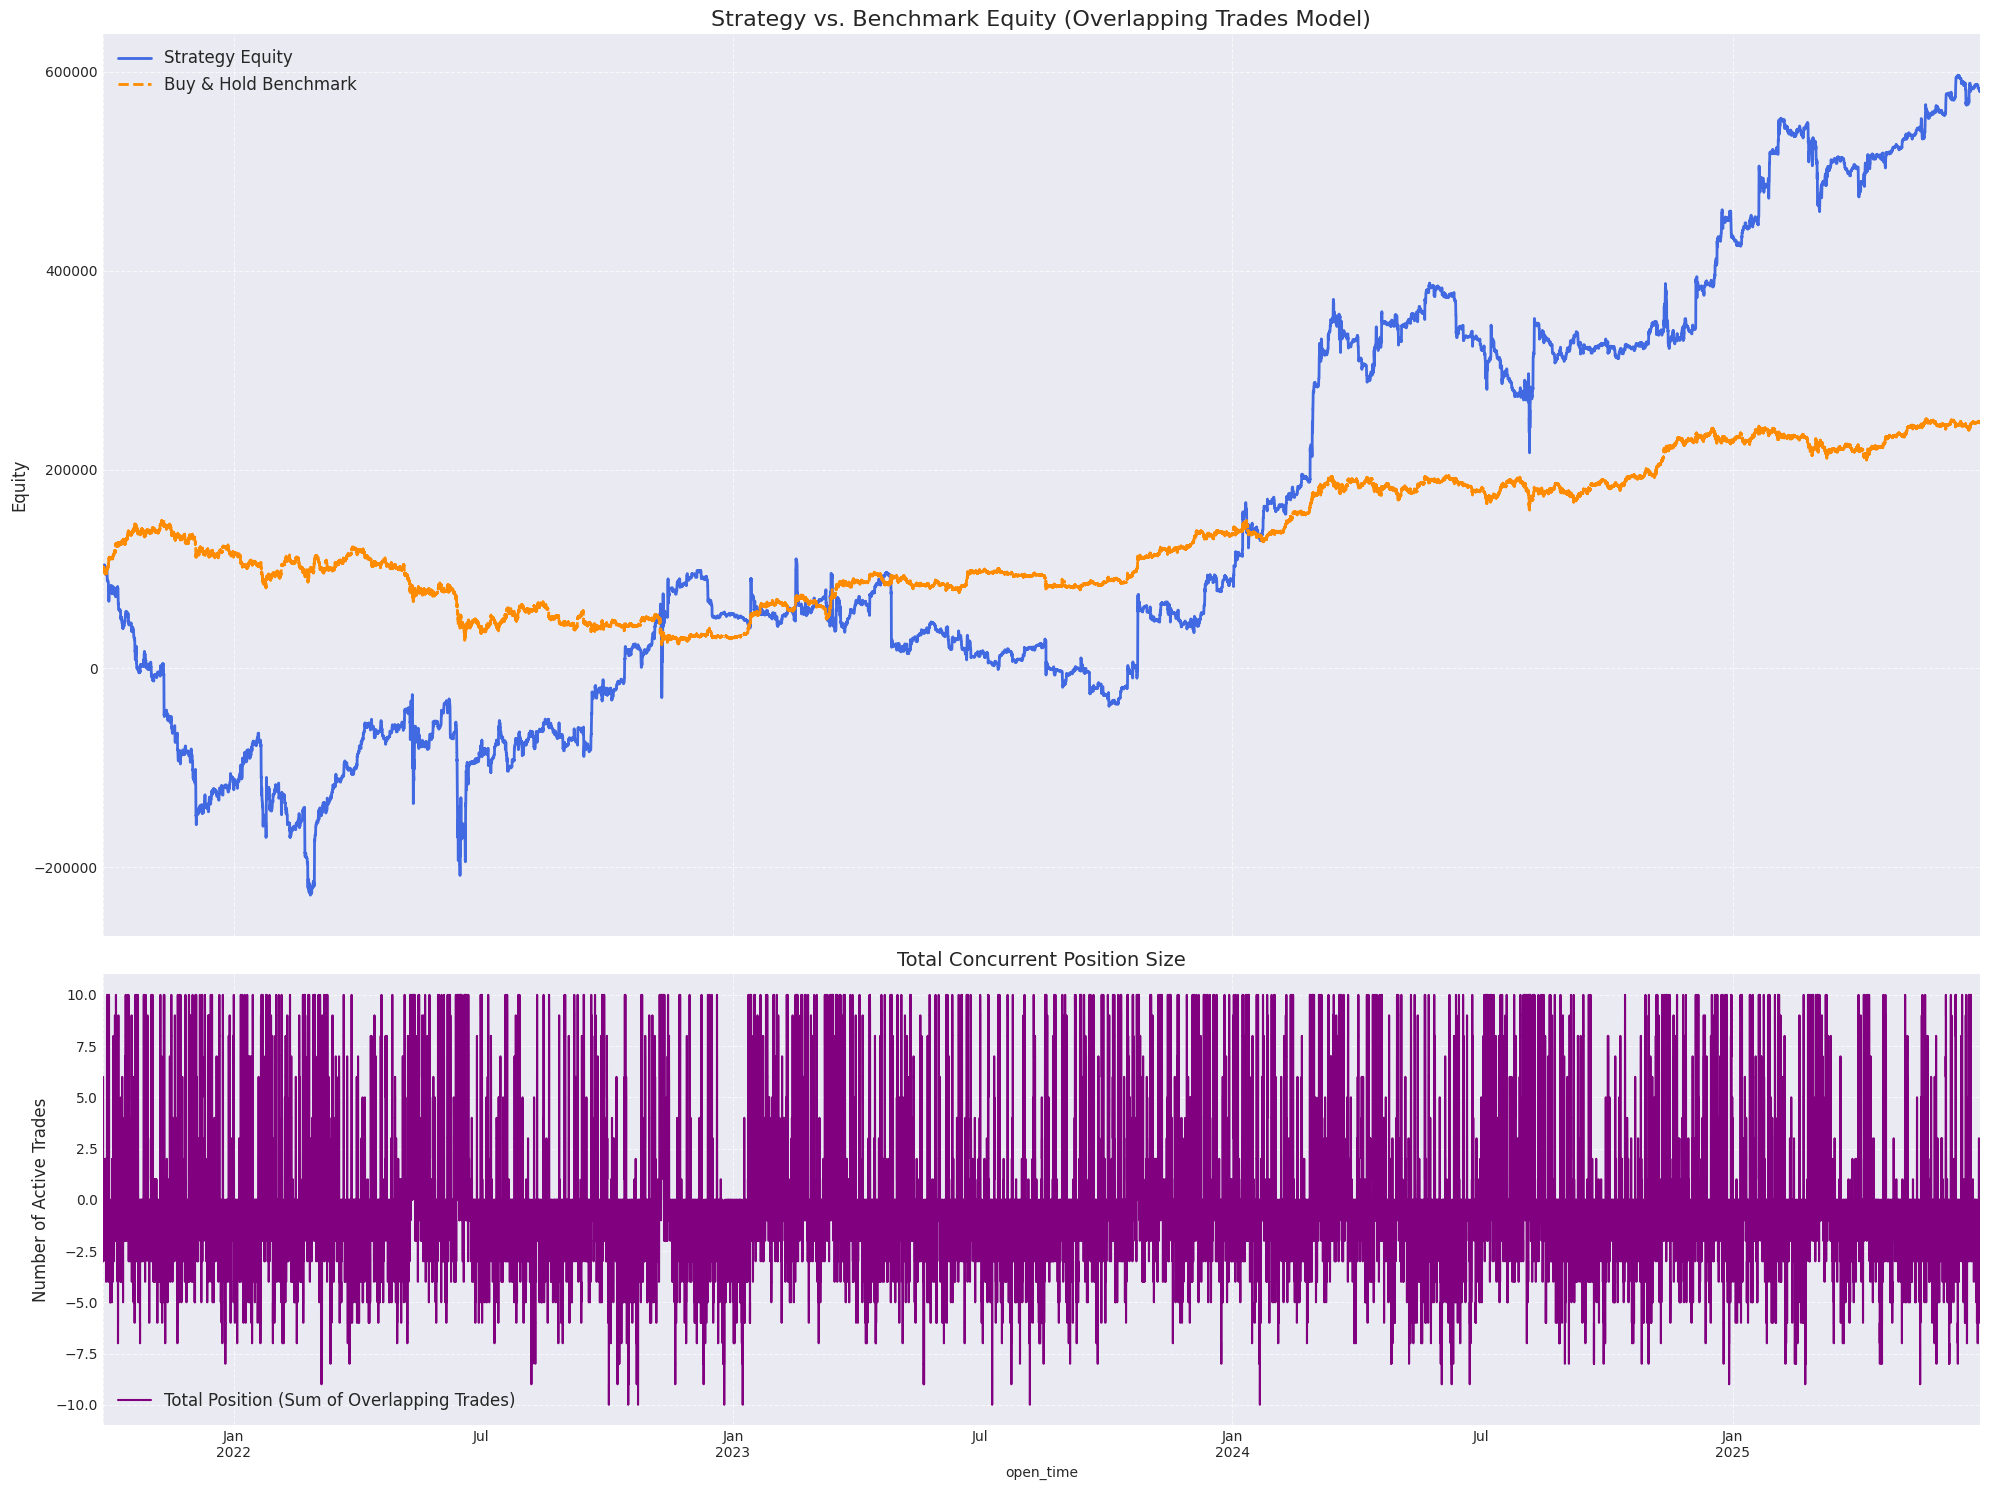

2025-07-24 10:59:47,569 - INFO - 🎊🎊🎊策略评估完成🎊🎊🎊


In [ ]:
if __name__ == '__main__':
    # --- 参数配置 ---
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    COMMISSION_RATE = 0.0002
    INITIAL_CAPITAL = 100000
    HOLDING_PERIOD = 10
    
    EVALUATION_CRITERIA = {
        'sharpe_ratio': 2.0,
        'calmar_ratio': 5.0,
        'expectancy': 0.25,
        'max_drawdown': 0.20,
        'weekly_frequency': 10
    }

    # --- 步骤 1: 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    
    backtest_data = pd.read_pickle(FILE_PATH)
    logging.info("数据加载成功。")

    # --- 步骤 2: 执行回测 ---
    # 修改接收返回值的变量，增加 gross_pnl_rates
    backtest_results, trade_list_series, gross_pnl_rates = run_overlapping_trades_backtest(
        prices=backtest_data['close'],
        signals=backtest_data['signal'],
        initial_capital=INITIAL_CAPITAL,
        commission_rate=COMMISSION_RATE,
        holding_period=HOLDING_PERIOD
    )

    # --- 【重要】新增：带教理智检查 (相关性检验) ---
    print("\n" + "="*80)
    print(Fore.YELLOW + Style.BRIGHT + " " * 30 + "相关性检验" + " " * 30 + Style.RESET_ALL)
    print("="*80)

    # 1. 获取策略的累计净收益 (已经扣除手续费)
    backtest_cumulative_net = backtest_results['strategy_net_returns'].cumsum()

    # 2. 构建理论上的累计毛收益 (不扣除手续费)
    #    这个逻辑必须和函数内生成净收益流的逻辑完全一致
    gross_pnl_rates_aligned = gross_pnl_rates.reindex(backtest_data['close'].index).fillna(0.0)
    theoretical_gross_stream = gross_pnl_rates_aligned.shift(HOLDING_PERIOD + 1).fillna(0.0)
    theoretical_cumulative_gross = theoretical_gross_stream.cumsum()

    # 3. 计算两个累计收益序列的相关性
    #    使用 .loc 对齐索引，避免因长度不一致导致计算错误
    common_index = backtest_cumulative_net.index.intersection(theoretical_cumulative_gross.index)
    correlation = backtest_cumulative_net.loc[common_index].corr(theoretical_cumulative_gross.loc[common_index])

    print(f"策略累计【净收益】与理论累计【毛收益】的相关系数为: {Fore.CYAN}{correlation:.8f}{Style.RESET_ALL}")
    if correlation > 0.999:
        print(Fore.GREEN + "✅ 相关性非常高，表明手续费的扣除方式正确，回测逻辑与理论一致。" + Style.RESET_ALL)
    else:
        print(Fore.RED + "❌ 相关性不高，请检查手续费计算或收益流的构建逻辑是否存在问题。" + Style.RESET_ALL)
    print("="*80 + "\n")


    # --- 步骤 3: 性能评估 ---
    evaluate_performance(
        backtest_results=backtest_results,
        trade_list_series=trade_list_series,
        evaluation_criteria=EVALUATION_CRITERIA,
        initial_capital=INITIAL_CAPITAL,
        factor_data=None 
    )